In [1]:
ON_COLAB = True

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
# other
import sys
sys.path.append('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/')
import params
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
import pandas as pd
import imageio
from csv import writer
from PIL import Image
!pip install trimesh
import trimesh
!pip install pyrender
import pyrender
if ON_COLAB:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
!pip install wandb
import wandb
!wandb login --relogin
# api_key = f2c3bd208d418cf11dcc2c2cbf5e4bc0fc104421

# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
par = params.Parameters()
print(par.epochs)
print(par.resume)
print(par.run_id)
print(par.batch_size)



11
False
3jkxyacc
128


In [4]:
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 

import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 

egl
None
None


In [5]:
#txt_path = par.txt_path
txt_path = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_6_txt'

def get_nth_line(fobj, n):
    for i in range(n):
        next(fobj)
    return next(fobj)

columns = ['id', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

with open('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_6.csv', 'w') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(columns)
    for f in Path(txt_path).iterdir():
        id = int(str(f).split('/')[-1].split('.txt')[0]) 
        file = open(f)
        line4 = get_nth_line(file, 4)
        line_splitted = line4.split(' ')
        writer_object.writerow([id] + line_splitted)
    f_object.close()

In [6]:
class PoseDataset(Dataset):

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        poses = pd.read_csv(csv_file)
        self.poses = poses.sort_values(by=["id"])
        self.root_dir = root_dir
    

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                str(self.poses.iloc[idx, 0]) + '-U_.png')
        
        img = imageio.imread(img_path, ignoregamma = True)
        rgb_img = img[:,:,:3]
        img_tensor = torch.tensor(rgb_img)/255.0
        img_tensor = np.transpose(img_tensor, (2, 0, 1))
        
        img_downsampled = F.interpolate(img_tensor, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        img_downsampled = F.interpolate(img_downsampled, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))

        pose = self.poses.iloc[idx, 1:]
        pose = np.array([pose])
        pose =  pose.reshape(6)      
        return img_downsampled, pose

In [7]:
pose_dataset_6 = PoseDataset(csv_file = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_6.csv',
                           root_dir='drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/RGB_6_images')
print(len(pose_dataset_6))

9


In [8]:
print('pose_dataset', pose_dataset_6[0])
'''img, pose = pose_dataset[0]
print(pose)
plt.figure()
plt.imshow(img)
plt.show()'''

pose_dataset (tensor([[[0.9137, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
         [0.9137, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
         [0.9137, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.8078, 0.8078, 0.8078,  ..., 0.0000, 0.0000, 0.0000],
         [0.8078, 0.8078, 0.8078,  ..., 0.0000, 0.0000, 0.0000],
         [0.8078, 0.8078, 0.8078,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4196, 0.4196, 0.4196,  ..., 0.0000, 0.0000, 0.0000],
         [0.4196, 0.4196, 0.4196,  ..., 0.0000, 0.0000, 0.0000],
         [0.4196, 0.4196, 0.4196,  ..., 0.00

'img, pose = pose_dataset[0]\nprint(pose)\nplt.figure()\nplt.imshow(img)\nplt.show()'

In [9]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist()),
    ]
)

'''# Create train val test split
n = len(pose_dataset)
n_1 = int(n/10)

train_set, val_set, test_set = torch.utils.data.random_split(
    pose_dataset, [n-(2*n_1), n_1, n_1])

print(len(train_set), len(val_set), len(test_set))

loader_train = DataLoader(train_set, batch_size=par.batch_size, shuffle=par.shuffle, num_workers=2)
loader_val = DataLoader(val_set, batch_size=par.batch_size, shuffle=par.shuffle, num_workers=2)
loader_test = DataLoader(test_set, batch_size=par.batch_size, shuffle=par.shuffle, num_workers=2)'''

loader_dataset_6 = DataLoader(pose_dataset_6, batch_size=1, shuffle=par.shuffle, num_workers=2)
print(len(loader_dataset_6))

9


In [8]:
### TO DO ### UNDERSTAND IF THE MEAN AND STD SHOULD BE DIFFERENT WRT THE OTHER EXAMPLE AND IF YES HOW

unnormalize = transforms.Normalize(
    (-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).clip(0, 1))

In [9]:
# define Resnet building blocks
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))
        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding=0, bias=False),
                                          nn.BatchNorm2d(outchannel))

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# define Resnet
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=6):
        super(ResNet, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.maxpool2 = nn.MaxPool2d(2, stride=1, padding=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        #print('x_shape', x.shape)
        x = self.conv1(x)
        #print('x_shape', x.shape)
        x = self.maxpool(x)
        #print('x_shape', x.shape)
        x = self.layer1(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer2(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer3(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer4(x)
        #print('x_shape', x.shape)
        #x = self.maxpool2(x)
        #print('x_shape', x.shape)
        #x = self.layer4(x)
        #print('x_shape', x.shape)
        x = self.avgpool(x)
        #print('x_shape', x.shape)
        x = x.view(x.size(0), -1)
        #print('x_shape', x.shape)
        x = self.fc(x)
        #print('x_shape', x.shape)
        return x

def MyResNet():
    return ResNet(ResidualBlock)

In [ ]:
dtype = torch.float32

if par.USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

print_every = par.print_every

def train_part(model, optimizer, epochs, start_e):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """

    iter_val = iter(loader_val)
    losses = []
    val_losses = []

    tra_losses = []
    tra_val_losses = []

    rot_losses = []
    rot_val_losses = []

    for e in tqdm(range(start_e, epochs)):
        for t, (x, y) in enumerate(tqdm(loader_train, leave=False)):

            try:
                x_val, y_val = next(iter_val)
            except StopIteration:
                iter_val = iter(loader_val)
                x_val, y_val = next(iter_val)

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #print('x', x)
            y = y.to(device=device, dtype=torch.float32)
            #print('y', y)
            y_tra = y[:, :3]
            #print('y_tra', y_tra)
            y_rot = y[:, 3:]
            #print('y_rot', y_rot)

            x_val = x_val.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_val = y_val.to(device=device, dtype=dtype)
            #print('y_val', y_val)
            y_val_tra = y_val[:, :3]
            #print('y_val_tra', y_val_tra)
            y_val_rot = y_val[:, 3:]
            #print('y_val_rot', y_val_rot)

            scores = model(x)
            #print('scores', (scores))
            scores_tra = scores[:, :3]
            #print('scores_tra', scores_tra)
            scores_rot = scores[:, 3:]
            #print('scores_rot', scores_rot)

            loss = F.mse_loss(scores, y)
            loss_tra = F.mse_loss(scores_tra, y_tra)
            loss_rot = F.mse_loss(scores_rot, y_rot)
            #print('loss', loss)
            losses.append(loss.item())
            tra_losses.append(loss_tra.item())
            rot_losses.append(loss_rot.item())

            scores_val = model(x_val)
            #print('scores_val', scores_val)
            scores_val_tra = scores_val[:, :3]
            #print('scores_val_tra', scores_val_tra)
            scores_val_rot = scores_val[:, 3:]
            #print('scores_val_rot', scores_val_rot)

            val_loss = F.mse_loss(scores_val, y_val)
            val_loss_tra = F.mse_loss(scores_val_tra, y_val_tra)
            val_loss_rot = F.mse_loss(scores_val_rot, y_val_rot)
            #print('val_loss', loss)
            val_losses.append(val_loss.item())
            tra_val_losses.append(val_loss_tra.item())
            rot_val_losses.append(val_loss_rot.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            wandb.log({
                "loss": loss,
                "val_loss": val_loss,
                "tra_loss [cm]": loss_tra,
                "tra_val_loss [cm]": val_loss_tra,
                "rot_loss [°]": loss_rot,
                "rot_val_loss [°]": val_loss_rot
                })
        

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss_tra.item()))
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss_rot.item()))

        torch.save({ # Save our checkpoint loc
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                "tra_loss [cm]": loss_tra,
                "tra_val_loss [cm]": val_loss_tra,
                "rot_loss [°]": loss_rot,
                "rot_val_loss [°]": val_loss_rot
                }, f"{par.checkpoint_path}/{run.id}.tar")
        wandb.save(f"{par.checkpoint_path}/{run.id}.tar") # saves checkpoint to wandb

    plt.figure(figsize=(10,7))
    plt.title("Learning curve traslations")
    plt.plot(tra_losses, label="Training loss")
    plt.plot(tra_val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()

    plt.figure(figsize=(10,7))
    plt.title("Learning curve rotations")
    plt.plot(rot_losses, label="Training loss")
    plt.plot(rot_val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()


cuda:0


In [10]:
print(par.run_id)
if par.resume:
    run = wandb.init(project="Deep Pose Estimation", 
                        entity="cuccomat",
                        id=par.run_id,
                        resume=True)
else:
    run = wandb.init(project="Deep Pose Estimation", 
            entity="cuccomat",
            config = {
                    "learning_rate": par.learning_rate,
                    "batch_size": par.batch_size,
                    "epochs": par.epochs
                })

3jkxyacc


wandb: Currently logged in as: cuccomat. Use `wandb login --relogin` to force relogin


In [ ]:
# define and train the network
torch.autograd.set_detect_anomaly(True)
model = MyResNet()
model = model.to(device=device)  # move the model parameters to CPU/GPU
optimizer = optim.Adamax(model.parameters(), lr=par.learning_rate, weight_decay=par.weight_decay)
epoch = 0
if wandb.run.resumed:
    wandb.restore(f"{par.checkpoint_path}/{par.run_id}.tar")
    checkpoint = torch.load(f"{par.checkpoint_path}/{par.run_id}.tar")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(epoch)

 
params_sum = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params_sum))

train_part(model, optimizer, epochs=par.epochs, start_e=epoch)

losses = []
val_losses = []

# report test set accuracy
#check_accuracy(loader_val, model, analysis=True)

# save the model
torch.save(model.state_dict(), 'model.pt')

NameError: name 'device' is not defined

In [10]:
def print_pose(model_path, pose, img):

    tm = trimesh.load(model_path) 
    mesh = pyrender.Mesh.from_trimesh(tm)
    pose = torch.squeeze(pose, dim=0) 
    print('xyz_rpy', pose.cpu().numpy().shape)
    tx, ty, tz, rx, ry, rz = pose.cpu().numpy()
    print('xyz_rpy', pose)

    r = R.from_euler('xyz',[rx, ry, rz], degrees=True)
    #r = R.from_euler('zyx',[rx, ry, rz], degrees=True)

    Twc = np.eye(4)
    Twc[:3,:3] = r.as_matrix()
    Twc[:3,3] = np.array([tx, ty, tz])

    Twc [0,1] *= -1
    Twc [1,0] *= -1
    Twc [1,2] *= -1
    Twc [2,1] *= -1

    Twc [0,3] *= -1

    print('Twc', Twc)

    im_width, im_height = (1024,1024)
    camK = np.array([[886.81,0.0,512.0],[0.0,886.81,512.0],[0.0,0.0,1.0]])

    camera = pyrender.IntrinsicsCamera(camK[0,0],camK[1,1],
                                        camK[0,2],camK[1,2], zfar = 500.0)

    scene=pyrender.Scene()
    scene.add(camera,pose=Twc)
    scene.add(mesh,pose=np.eye(4))
    r = pyrender.OffscreenRenderer(im_width, im_height)
    color,depth = r.render(scene)

    # Flip y in image space
    color = color[::-1,:,:]
    depth = depth[::-1,:]

    # Flip x in image space
    color = color[:,::-1,:]
    depth = depth[:,::-1]

    # Overlap the two images for comparision
    plt.figure()
    plt.imshow(img, alpha = 0.6, cmap = plt.cm.gray)
    plt.imshow(depth, alpha = 0.4, cmap = plt.cm.gray_r)
    plt.show()   
                    

In [36]:
from scipy.spatial.transform import Rotation as R

# TEST
#Is it possibile to set an initial value for traslations and rotations?
def test_part(model):
    iter_test = iter(loader_test)
    print('YES1')
    with torch.no_grad():
        for t, (x, y) in enumerate(tqdm(loader_test, leave=False)):
            print('x', x[t])
            print('y', y[t])
            try:
                x_test, y_test = next(iter_test)
            except StopIteration:
                iter_test = iter(loader_test)
                x_test, y_test = next(iter_test)

            x_test = x_test.to(device=device, dtype=dtype)
            #print('x_test', x_test.shape)
            print('x_test_primo', x_test[1, :, :, :].shape)
            y_test = y_test.to(device=device, dtype=dtype)
            predictions = model(x_test)
            for t, xyz_rpy in enumerate(predictions):
                transform = transforms.ToPILImage()
                image = transform(x_test[t, :, :, :])
                pose = print_pose(model_path=par.tm_path, pose=xyz_rpy, img=image)
                 

9


  0%|          | 0/9 [00:00<?, ?it/s]

xyz_rpy (6,)
xyz_rpy tensor([  11.0000,   41.0000, -251.0000, -179.9999,   40.1027,   -0.4948],
       dtype=torch.float64)
Twc [[ 7.64862658e-01  8.63741515e-03 -6.44135475e-01 -1.10000000e+01]
 [ 6.60563358e-03 -9.99962697e-01 -5.56511887e-03  4.10000000e+01]
 [-6.44159515e-01  1.62868408e-06 -7.64891181e-01 -2.51000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


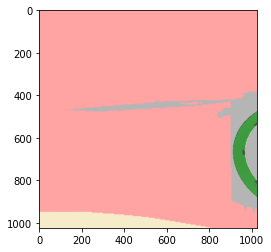

xyz_rpy (6,)
xyz_rpy tensor([  60.0000,  -53.0000, -192.0000, -179.9999,    7.9389, -151.2546],
       dtype=torch.float64)
Twc [[-8.68362433e-01  4.80917999e-01  1.21097330e-01 -6.00000000e+01]
 [ 4.76309090e-01  8.76765578e-01 -6.64211718e-02 -5.30000000e+01]
 [-1.38117108e-01  2.10889426e-06 -9.90415905e-01 -1.92000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


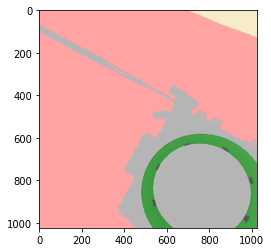

xyz_rpy (6,)
xyz_rpy tensor([ -19.0000,  -39.0000, -126.0000, -179.9999,   26.2130,  -31.4888],
       dtype=torch.float64)
Twc [[ 7.65044705e-01  5.22333186e-01 -3.76662504e-01  1.90000000e+01]
 [ 4.68614811e-01 -8.52741487e-01 -2.30720861e-01 -3.90000000e+01]
 [-4.41708906e-01  2.14519648e-06 -8.97158426e-01 -1.26000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


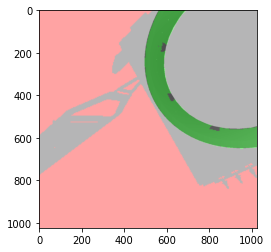

xyz_rpy (6,)
xyz_rpy tensor([  57.0000,   23.0000, -128.0000, -179.9999,   35.2135,   67.8757],
       dtype=torch.float64)
Twc [[ 3.07700045e-01 -9.26368332e-01 -2.17169048e-01 -5.70000000e+01]
 [-7.56851723e-01 -3.76618790e-01  5.34166412e-01  2.30000000e+01]
 [-5.76624793e-01  1.73965883e-06 -8.17009087e-01 -1.28000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


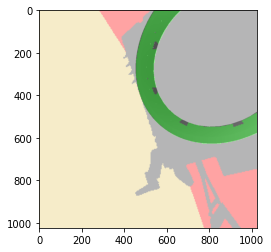

xyz_rpy (6,)
xyz_rpy tensor([  70.0000,   21.0000, -120.0000, -179.9999,   30.3380,  -68.9386],
       dtype=torch.float64)
Twc [[ 3.10156116e-01  9.33196470e-01 -1.81514549e-01 -7.00000000e+01]
 [ 8.05405039e-01 -3.59366592e-01 -4.71358011e-01  2.10000000e+01]
 [-5.05099897e-01  1.83771700e-06 -8.63060886e-01 -1.20000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


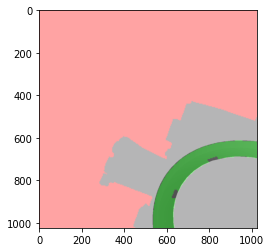

xyz_rpy (6,)
xyz_rpy tensor([ -53.0000,   35.0000, -280.0000, -179.9999,   12.7805,  146.5601],
       dtype=torch.float64)
Twc [[-8.13789938e-01 -5.51062973e-01  1.84595603e-01  5.30000000e+01]
 [-5.37409914e-01  8.34463660e-01  1.21905641e-01  3.50000000e+01]
 [-2.21216008e-01  2.07654789e-06 -9.75224835e-01 -2.80000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


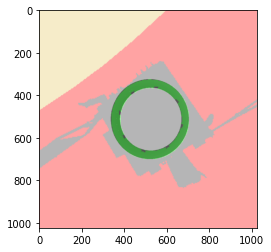

xyz_rpy (6,)
xyz_rpy tensor([  50.0000,   28.0000, -127.0000, -179.9999,   19.4631,   -2.9371],
       dtype=torch.float64)
Twc [[ 9.41617503e-01  5.12399599e-02 -3.32762596e-01 -5.00000000e+01]
 [ 4.83112372e-02 -9.98686370e-01 -1.70750653e-02  2.80000000e+01]
 [-3.33200395e-01  2.00762494e-06 -9.42856032e-01 -1.27000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


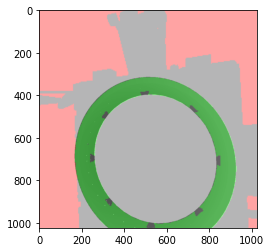

xyz_rpy (6,)
xyz_rpy tensor([  56.0000,  -21.0000,  -57.0000, -179.9999,   14.3273,   15.4420],
       dtype=torch.float64)
Twc [[ 9.33921268e-01 -2.66261450e-01 -2.38528628e-01 -5.60000000e+01]
 [-2.57980623e-01 -9.63900846e-01  6.58874610e-02 -2.10000000e+01]
 [-2.47461237e-01  2.06307571e-06 -9.68897794e-01 -5.70000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


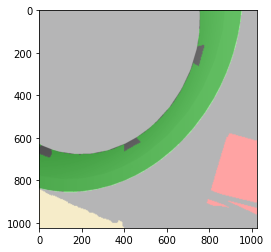

xyz_rpy (6,)
xyz_rpy tensor([  49.0000,  -21.0000, -295.0000, -179.9999,   17.0816,  155.5368],
       dtype=torch.float64)
Twc [[-8.70074928e-01 -4.14109212e-01  2.67363386e-01 -4.90000000e+01]
 [-3.95841218e-01  9.10227203e-01  1.21639505e-01 -2.10000000e+01]
 [-2.93733466e-01  2.03537258e-06 -9.55887363e-01 -2.95000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


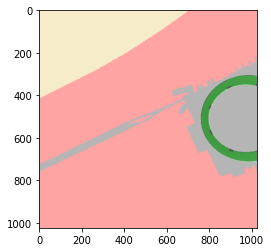

In [11]:
from scipy.spatial.transform import Rotation as R
print(len(loader_dataset_6))
for t, (x, y) in enumerate(tqdm(loader_dataset_6, leave=False)):
    transform = transforms.ToPILImage()
    x = torch.squeeze(x, dim=0) 
    image_upsampled = F.interpolate(x, scale_factor = 2)
    image_upsampled = np.transpose(image_upsampled, (0, 2, 1))
    image_upsampled = F.interpolate(image_upsampled, scale_factor = 2)
    image_upsampled = np.transpose(image_upsampled, (0, 2, 1))
    image_upsampled = F.interpolate(image_upsampled, scale_factor = 2)
    image_upsampled = np.transpose(image_upsampled, (0, 2, 1))
    image_upsampled = F.interpolate(image_upsampled, scale_factor = 2)
    image_upsampled = np.transpose(image_upsampled, (0, 2, 1))
    image = transform(image_upsampled)
    #img_ddble = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
    pose = print_pose(model_path=par.tm_path, pose=y, img=image)

cuda
YES1


  0%|          | 0/8 [00:00<?, ?it/s]

x tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 

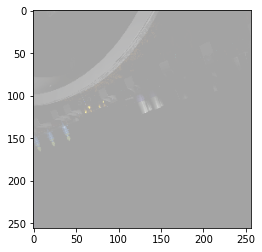

xyz_rpy tensor([268.8203, -37.3060, 201.2127, -55.8614,  -8.0396,  94.0441],
       device='cuda:0')
Twc [[-6.98310941e-02  5.67962985e-01 -8.20086377e-01 -2.68820312e+02]
 [-9.87706178e-01  7.58914326e-02  1.36663809e-01 -3.73059807e+01]
 [ 1.39857515e-01  8.19547764e-01  5.55680968e-01  2.01212723e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


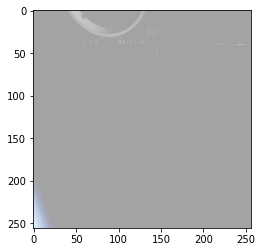

xyz_rpy tensor([ 239.7054,   70.7865,  -95.6471, -100.1596,   27.5056,   96.4994],
       device='cuda:0')
Twc [[-1.00397717e-01 -2.26713027e-01 -9.68773194e-01 -2.39705383e+02]
 [-8.81265007e-01 -4.31706709e-01  1.92357232e-01  7.07865372e+01]
 [-4.61835778e-01  8.73058143e-01 -1.56451889e-01 -9.56470871e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


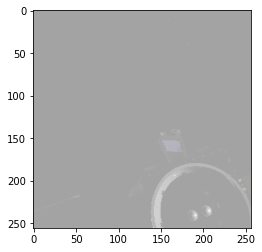

KeyboardInterrupt: ignored

In [14]:
dtype = torch.float32

device = torch.device('cuda')
print(device)

model = MyResNet()
model = model.to(device=device)
checkpoint = torch.load(f"{par.checkpoint_path}/{par.run_id}.tar")
model.load_state_dict(checkpoint['model_state_dict'])

test_part(model)